In [1]:
# importing all the required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import IPython.display as ipd

In [2]:
np.random.seed(6)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import glob

In [ ]:
FILEPATH = 'drive/MyDrive/DATA/RAVDESS-dataset/visual_frames2/*/*.npy'
all_video_files = sorted(glob.glob(FILEPATH))
len(all_video_files)

In [ ]:
# !cp -rv drive/MyDrive/DATA/RAVDESS-dataset/visual_frames2 visual_frames2

In [ ]:
from tqdm import tqdm
import os

In [ ]:
label_to_emotion = {'01':'neutral', 
                    '02': 'calm', 
                    '03': 'happy',
                    '04': 'sad',
                    '05': 'angry',
                    '06': 'fearful',
                    '07': 'disgust',
                    '08': 'surprised'}

In [ ]:
FILES = {'filepath':[], 
         'label':[], 
         'emotion': [],
         'actor':[], 
         'intensity': []}
want_duration = False
for file in tqdm(all_video_files):
  # label = os.path.dirname(os.path.basename(file))
  filename = os.path.basename(file).replace('.npy', '').split('=')[1]
  label = os.path.basename(filename).split('-')[2]
  intensity = os.path.basename(filename).split('-')[3]
  actor = os.path.basename(filename).split('-')[-1]
  
  # # filling the dictionary
  FILES['filepath'].append(file)
  FILES['label'].append(label)
  FILES['emotion'].append(label_to_emotion[label])
  FILES['actor'].append(actor)
  FILES['intensity'].append(intensity)

In [ ]:
df = pd.DataFrame(FILES)
df

In [ ]:
from collections import Counter

Counter(df.emotion)

In [11]:
# to split the data into training and validation
from sklearn.model_selection import train_test_split

In [12]:
train_df, dev_df = train_test_split(df, shuffle=True, stratify=df['label'], test_size=0.15, random_state=6)
dev_df, test_df = train_test_split(dev_df, shuffle=True, stratify=dev_df['label'], test_size=0.5, random_state=6)

In [13]:
train_df.shape, dev_df.shape, test_df.shape

((52761, 5), (4655, 5), (4656, 5))

In [14]:
print(Counter(train_df.emotion))
print(Counter(dev_df.emotion))
print(Counter(test_df.emotion))

Counter({'calm': 8671, 'sad': 8413, 'angry': 8294, 'happy': 8089, 'fearful': 7830, 'disgust': 3993, 'neutral': 3922, 'surprised': 3549})
Counter({'calm': 765, 'sad': 742, 'angry': 732, 'happy': 713, 'fearful': 691, 'disgust': 353, 'neutral': 346, 'surprised': 313})
Counter({'calm': 765, 'sad': 743, 'angry': 732, 'happy': 714, 'fearful': 691, 'disgust': 352, 'neutral': 346, 'surprised': 313})


In [15]:
from torchvision import transforms

In [16]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize(50),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])

In [17]:
tmp_img = np.load(df.iloc[45].filepath)

Text(0.5, 1.0, 'Sample Image')

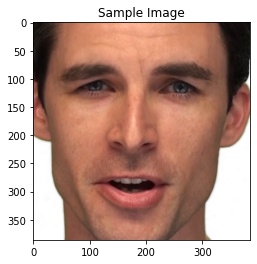

In [19]:
plt.imshow(tmp_img)
plt.title("Sample Image")

In [20]:
tmp_img_tensor = train_transforms(tmp_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Sample Image')

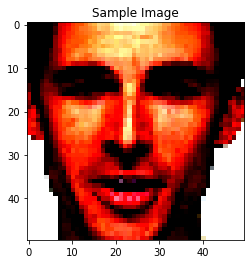

In [21]:
plt.imshow(tmp_img_tensor.permute(1, 2, 0))
plt.title("Sample Image")

In [46]:
class ImageDatasetLoader_nostack(torch.utils.data.Dataset):
  def __init__(self, df, transforms):
    self.df = df
    self.transforms = transforms
    self.SIZE = 50
  def __len__(self):
    return self.df.shape[0]
  def __getitem__(self, idx):
    line = self.df.iloc[idx]
    arr = np.load(line.filepath)
    arr_ten = self.transforms(arr)
    label = torch.Tensor([int(line.label) - 1])
    return arr_ten[:, :self.SIZE, :self.SIZE], label

In [59]:
# train_dataset = ImageDatasetLoader_nostack(train_df, train_transforms)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [58]:
# for i, batch in enumerate(train_dataloader):
#   print(i, batch)
#   break

In [56]:
# batch[0].shape

In [57]:

# for i in range(32):
#   plt.subplot(6, 6, i+1)
#   plt.imshow(batch[0][i].permute(1, 2, 0))

In [61]:
train_dataset = ImageDatasetLoader_nostack(df=train_df, transforms=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               shuffle=True, 
                                               batch_size=128, 
                                               num_workers=8)


dev_dataset = ImageDatasetLoader_nostack(df=dev_df, transforms=train_transforms)
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, 
                                             shuffle=False, 
                                             batch_size=32, 
                                             num_workers=8)

test_dataset = ImageDatasetLoader_nostack(df=test_df, transforms=train_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                             shuffle=False, 
                                             batch_size=32, 
                                             num_workers=8)

In [62]:
print(len(train_dataset), len(dev_dataset), len(test_dataset))
print(len(train_dataloader), len(dev_dataloader), len(test_dataloader))

52761 4655 4656
413 146 146


In [86]:
class SimpleCNNblock(torch.nn.Module):
  def __init__(self, inc, outc, k, s):
    super().__init__()
    self.conv = torch.nn.Conv2d(inc, outc, k, stride=s)
    self.bn = torch.nn.BatchNorm2d(outc)
    self.dropout = torch.nn.Dropout2d(p=0.1)
    self.relu = torch.nn.ReLU(inplace=True)
  def forward(self, X):
    out = self.conv(X)
    out = self.bn(out)
    out = self.dropout(out)
    out = self.relu(out)
    return out

class SimpleCNNclassifier(torch.nn.Module):
  def __init__(self, num_classes=8):
    super().__init__()
    self.block1 = SimpleCNNblock(3, 64, 3, 1)
    self.block2 = SimpleCNNblock(64, 128, 3, 1)
    self.block3 = SimpleCNNblock(128, 128, 3, 2)
    self.block4 = SimpleCNNblock(128, 256, 3, 2)
    self.block5 = SimpleCNNblock(256, 256, 3, 2)
    lin_size = 4096
    self.flatten = torch.nn.Flatten()
    self.linear = torch.nn.Linear(lin_size, num_classes)
  def forward(self, X):
    out = self.block1(X)
    out = self.block2(out)
    out = self.block3(out)
    out = self.block4(out)
    out = self.block5(out)
    out = self.flatten(out)
    out = self.linear(out)
    return out

In [90]:
model_cnn_v1 = SimpleCNNclassifier()
model_cnn_v1

SimpleCNNclassifier(
  (block1): SimpleCNNblock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout2d(p=0.1, inplace=False)
    (relu): ReLU(inplace=True)
  )
  (block2): SimpleCNNblock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout2d(p=0.1, inplace=False)
    (relu): ReLU(inplace=True)
  )
  (block3): SimpleCNNblock(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout2d(p=0.1, inplace=False)
    (relu): ReLU(inplace=True)
  )
  (block4): SimpleCNNblock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d

In [91]:
DEVICE = 'cuda'
model_cnn_v1.to(DEVICE)

SimpleCNNclassifier(
  (block1): SimpleCNNblock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout2d(p=0.1, inplace=False)
    (relu): ReLU(inplace=True)
  )
  (block2): SimpleCNNblock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout2d(p=0.1, inplace=False)
    (relu): ReLU(inplace=True)
  )
  (block3): SimpleCNNblock(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout2d(p=0.1, inplace=False)
    (relu): ReLU(inplace=True)
  )
  (block4): SimpleCNNblock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d

In [93]:
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model_cnn_v1.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=1)

In [94]:
def get_accuracy(yhat, y):
  return (yhat.argmax(1)==y).float().mean()


def train_one_epoch_cnn(model, dataset, criterion, optim, epoch):
  model.train()
  losses = []
  accus = []
  stime = time.time()
  pbar = tqdm(dataset)
  for i, batch in enumerate(pbar):
    feats = batch[0].to(DEVICE)
    labels = batch[1].flatten().to(DEVICE)

    outs = model(feats)

    optim.zero_grad()
    l = criterion(outs, labels.long())
    l.backward()
    optim.step()

    losses.append(l.item())
    accu = get_accuracy(outs, labels)
    accus.append(accu.item())

    accuracy_avg = sum(accus)/len(accus)
    loss_avg = sum(losses)/len(losses)
    pbar.set_description(f"Progress - Accu: {accuracy_avg:.3f}\tLoss: {loss_avg:.3f}")

  etime = time.time()
  accuracy_avg = sum(accus)/len(accus)
  loss_avg = sum(losses)/len(losses)
  time_total = etime - stime
  print(f'[TRAIN] Epoch: {epoch}\tAccu: {accuracy_avg}\tLoss: {loss_avg}\tTime: {time_total:.3f} secs')
  return loss_avg, accuracy_avg, time_total

@torch.no_grad()
def evaluate_model(model, dataset, criterion, epoch):
  model.eval()
  losses = []
  accus = []
  stime = time.time()
  for i, batch in enumerate(dataset):
    feats = batch[0].to(DEVICE)
    labels = batch[1].flatten().to(DEVICE)

    outs = model(feats)

    l = criterion(outs, labels.long())

    losses.append(l.item())
    accu = get_accuracy(outs, labels)
    accus.append(accu.item())
  etime = time.time()
  accuracy_avg = sum(accus)/len(accus)
  loss_avg = sum(losses)/len(losses)
  time_total = etime - stime
  print(f'[VALID] Epoch: {epoch}\tAccu: {accuracy_avg}\tLoss: {loss_avg}\tTime: {time_total:.3f} secs')
  return loss_avg, accuracy_avg, time_total

In [95]:
get_lr = lambda optim: optim.param_groups[0]['lr']

In [96]:
import warnings
warnings.filterwarnings('ignore')

In [99]:
N_EPOCHS = 50
best_training_loss = 1000
best_validation_loss = 1000

best_training_accuracy = 0
best_validation_accuracy = 0

best_training_epoch = -1
best_validation_epoch = -1
STIME = time.time()
for epoch in range(1, N_EPOCHS + 1):
  # training the model for one epoch
  print(f"Starting Training epoch: {epoch}")
  train_loss_avg, train_accuracy_avg, train_time_total = train_one_epoch_cnn(model_cnn_v1, train_dataloader, criterion, optim, epoch)

  # evaluate the model one epoch
  print(f"Starting Evaluation epoch: {epoch}")
  dev_loss_avg, dev_accuracy_avg, dev_time_total = evaluate_model(model_cnn_v1, dev_dataloader, criterion, epoch)

  # scheduler
  scheduler.step(dev_loss_avg)
  print(f"Learning rate at epoch: {epoch} is {get_lr(optim)}")

  if train_loss_avg < best_training_loss:
    best_training_loss = train_loss_avg
    print(f"Best training loss updated at epoch: {epoch} as {best_training_loss}")
  
  if dev_loss_avg < best_validation_loss:
    best_validation_loss = dev_loss_avg
    print(f"Best validation loss updated at epoch: {epoch} as {dev_loss_avg}")
  
  if train_accuracy_avg > best_training_accuracy:
    best_training_accuracy = train_accuracy_avg
    best_training_epoch = epoch
    print(f"Best training accuracy updated at epoch: {epoch} as {best_training_loss}")
  
  if dev_accuracy_avg > best_validation_accuracy:
    best_validation_accuracy = dev_accuracy_avg
    best_validation_epoch = epoch
    print(f"Best validation accuracy updated at epoch: {epoch} as {best_validation_loss}")
ETIME = time.time()
print(f"\n\nSTATS\nTraining done in: {ETIME-STIME:.3f} secs")
print(f"Best Training Loss: {best_training_loss:.3f} at epoch: {best_training_epoch}")
print(f"Best Validation Loss: {best_validation_loss:.3f} at epoch: {best_validation_epoch}")

print(f"Best Training Accuracy: {best_training_accuracy:.3f} at epoch: {best_training_epoch}")
print(f"Best Validation Accuracy: {best_validation_accuracy:.3f} at epoch: {best_validation_epoch}")


Starting Training epoch: 1


Progress - Accu: 0.423	Loss: 1.599:  20%|█▉        | 82/413 [20:10<1:21:24, 14.76s/it]


RuntimeError: ignored